# Additional simulations results:

In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as st

from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use("seaborn-v0_8-white")

from clover.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit, RegressionSplit
from acpi import ACPI
from clover.scores import RegressionScore, LocalRegressionScore
import time

from clover.locart import LocartSplit, MondrianRegressionSplit
from clover.scores import RegressionScore
from clover.simulation import simulation, make_correlated_design
from clover.utils import compute_interval_length, split, real_coverage, smis

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Defining function to run new simulated example:

In [2]:
def run_additional_example(
    n_train = 10000,
    kind="homoscedastic",
    p=1,
    d=20,
    t_degree=4,
    base_model=RandomForestRegressor,
    sig=0.1,
    hetero_value=0.25,
    asym_value=0.6,
    calib_size = 0.5,
    coef = 2,
    rate = 1,
    rho = 0.7,
    B_x = 5000,
    B_y = 1000, 
    random_seed_X = 850,
    random_seed = 1250,
    random_projections=False,
    split_seed = 125,
    h=20,
    m=300,
    split_calib=False,
    split_mondrian=False,
    nbins=30,
    criterion="squared_error",
    max_depth=None,
    max_leaf_nodes=None,
    min_samples_leaf=150,
    prune=True,
    **kwargs):
    
    noise = (p == 1)

    # setting simulation object
    sim_obj = simulation(
        dim = d, 
        coef = coef,
        signif_vars=p,
        hetero_value = hetero_value, 
        asym_value = asym_value, 
        noise = noise, 
        rate = rate,
        t_degree = t_degree,
        rho = rho,
        )
    r_kind = getattr(sim_obj, kind + "_r")
    sim_kind = getattr(sim_obj, kind)

    # generating testing samples
    if kind == "splitted_exp":
        np.random.seed(random_seed_X)
        X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))

    elif kind == "correlated_homoscedastic" or kind == "correlated_heteroscedastic":
        X_test = make_correlated_design(n_samples = B_x, n_features = d, rho = rho, random_state = random_seed_X)
        
    else:
        np.random.seed(random_seed_X)
        X_test = np.random.uniform(low = -1.5, high = 1.5, size=(B_x, d))
        
    if noise:
        X_grid = X_test[:, 0]
    else:
        X_grid = X_test

    # generating y_test
    y_test = r_kind(X_grid, B=1).flatten()
    sim_kind(2 * n_train, random_seed=random_seed)
    
    data = split(
        sim_obj.X,
        sim_obj.y,
        test_size=calib_size,
        calibrate=False,
        random_seed=split_seed,
    )

    # matrix of y's associated to each X in test set
    y_mat = r_kind(X_grid, B = B_y)

    # fitting model
    model = base_model(**kwargs).fit(data["X_train"], data["y_train"])
        
    # fitting locart
    print("Fitting locart to toy example:")
    start_loc = time.time()
    locart_obj = LocartSplit(
                    nc_score=RegressionScore,
                    cart_type="CART",
                    base_model=model,
                    is_fitted=True,
                    alpha=sig,
                    split_calib=split_calib,
                    **kwargs
                )
    locart_obj.fit(data["X_train"], data["y_train"])
    locart_obj.calib(
        data["X_test"],
        data["y_test"],
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        prune_tree=prune,
        random_projections=random_projections,
        m=m,
        h=h,
    )
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    
    # predictions
    locart_pred = np.array(locart_obj.predict(X_test))
    cond_locart_real = real_coverage(locart_pred, y_mat)

    # average distance
    dif_locart = np.abs(cond_locart_real - (1 - sig))
    locart_ave_dist = np.mean(dif_locart)

    # marginal coverage
    marg_cover = (
                    np.logical_and(
                        y_test >= locart_pred[:, 0], y_test <= locart_pred[:, 1]
                    )
                    + 0
                )
    locart_ave_marginal_cov = np.mean(marg_cover)

    # smis
    locart_smis = smis(locart_pred, y_test, alpha=sig)

    # mean interval length
    locart_interval_len = np.mean(compute_interval_length(locart_pred))

     # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    locart_interval_len_cover = np.mean(compute_interval_length(locart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics: ", end_loc)

    print("Fitting loforest to example:")
    start_loc = time.time()
    loforest_obj = LocartSplit(nc_score = RegressionScore, base_model = model, cart_type = "RF", alpha = sig, split_calib = split_calib, is_fitted = True,
                             weighting = False, **kwargs)
    loforest_obj.fit(data["X_train"], data["y_train"])
    loforest_obj.calib(data["X_test"], data["y_test"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit Loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    
    # predictions
    loforest_pred = np.array(loforest_obj.predict(X_test))
    cond_loforest_real = real_coverage(loforest_pred, y_mat)

    # average, median and max distance
    dif_loforest = np.abs(cond_loforest_real - (1 - sig))
    loforest_ave_dist = np.mean(dif_loforest)

    # smis
    loforest_smis = smis(loforest_pred, y_test, alpha = sig)

    # mean interval length
    loforest_interval_len = np.mean(compute_interval_length(loforest_pred))

    # marginal coverage
    marg_cover = np.logical_and(y_test >= loforest_pred[:, 0], 
        y_test <= loforest_pred[:, 1]) + 0
    loforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    loforest_interval_len_cover = np.mean(compute_interval_length(loforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for Loforest: ", end_loc)

    # fitting A-locart
    print("Fitting A-locart to toy example:")
    start_loc = time.time()
    alocart_obj = LocartSplit(
                    nc_score=RegressionScore,
                    cart_type="CART",
                    base_model=model,
                    weighting=True,
                    is_fitted=True,
                    alpha=sig,
                    split_calib=split_calib,
                    **kwargs
                )
    alocart_obj.fit(data["X_train"], data["y_train"])
    alocart_obj.calib(
        data["X_test"],
        data["y_test"],
        max_depth=max_depth,
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        prune_tree=prune,
        random_projections=random_projections,
        m=m,
        h=h,
    )
    
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit A-Locart: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    
    # predictions
    alocart_pred = np.array(alocart_obj.predict(X_test))
    cond_alocart_real = real_coverage(alocart_pred, y_mat)

    # average distance
    dif_alocart = np.abs(cond_alocart_real - (1 - sig))
    alocart_ave_dist = np.mean(dif_alocart)

    # marginal coverage
    marg_cover = (
                    np.logical_and(
                        y_test >= alocart_pred[:, 0], y_test <= alocart_pred[:, 1]
                    )
                    + 0
                )
    alocart_ave_marginal_cov = np.mean(marg_cover)

    # smis
    alocart_smis = smis(alocart_pred, y_test, alpha=sig)

    # mean interval length
    alocart_interval_len = np.mean(compute_interval_length(alocart_pred))

     # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    alocart_interval_len_cover = np.mean(compute_interval_length(alocart_pred[cover_idx]))

    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics: ", end_loc)

    print("Fitting A-loforest to example:")
    start_loc = time.time()
    aloforest_obj = LocartSplit(nc_score = RegressionScore, base_model = model, cart_type = "RF", alpha = sig, split_calib = split_calib, is_fitted = True,
                             weighting = True, **kwargs)
    aloforest_obj.fit(data["X_train"], data["y_train"])
    aloforest_obj.calib(data["X_test"], data["y_test"], max_depth = max_depth, 
    max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
    end_loc = time.time() - start_loc
    print("Time Elapsed to fit A-loforest: ", end_loc)

    print("Computing metrics")
    start_loc = time.time()
    
    # predictions
    aloforest_pred = np.array(aloforest_obj.predict(X_test))
    cond_aloforest_real = real_coverage(aloforest_pred, y_mat)

    # average, median and max distance
    dif_aloforest = np.abs(cond_aloforest_real - (1 - sig))
    aloforest_ave_dist = np.mean(dif_aloforest)

    # smis
    aloforest_smis = smis(aloforest_pred, y_test, alpha = sig)

    # mean interval length
    aloforest_interval_len = np.mean(compute_interval_length(aloforest_pred))

    # marginal coverage
    marg_cover = np.logical_and(y_test >= aloforest_pred[:, 0], 
        y_test <= aloforest_pred[:, 1]) + 0
    aloforest_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    aloforest_interval_len_cover = np.mean(compute_interval_length(aloforest_pred[cover_idx]))
    end_loc = time.time() - start_loc
    print("Time Elapsed to compute metrics for A-loforest: ", end_loc)


    # fitting default regression split
    print("Fitting regression split")
    start_split = time.time()
    icp = RegressionSplit(base_model = model, alpha = sig, is_fitted = True, **kwargs)
    icp.fit(data["X_train"], data["y_train"])
    icp.calibrate(data["X_test"], data["y_test"])

    # nc = NcFactory.create_nc(model)
    # icp = IcpRegressor(nc)
    # icp.fit(data["X_train"], data["y_train"])
    # icp.calibrate(data["X_test"], data["y_test"])

    end_split = time.time() - start_split
    print("Time Elapsed to fit regression split: ", end_split)

    print("Computing metrics")
    start_split = time.time()

    # predictions
    # icp_pred = icp.predict(X_test, significance = sig)
    icp_pred = icp.predict(X_test)
    cond_icp_real = real_coverage(icp_pred, y_mat)
    
    # average, median and max distance
    dif_icp = np.abs(cond_icp_real - (1 - sig))
    icp_ave_dist = np.mean(dif_icp)

    # icp smis
    icp_smis = smis(icp_pred, y_test, alpha = sig)

    # ICP interval length
    icp_interval_len = np.mean(compute_interval_length(icp_pred))

    # marginal coverage
    marg_cover = np.logical_and(y_test >= icp_pred[:, 0], 
        y_test <= icp_pred[:, 1]) + 0
    icp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    icp_interval_len_cover = np.mean(compute_interval_length(icp_pred[cover_idx]))

    end_split = time.time() - start_split
    print("Time Elapsed to compute statistics for regression split: ", end_split)

    # fitting wighted regression split
    print("Fitting weighted regression split")
    start_weighted_split = time.time()
    wicp = LocalRegressionSplit(model, alpha = sig, is_fitted = True, **kwargs)
    wicp.fit(data["X_train"], data["y_train"])
    wicp.calibrate(data["X_test"], data["y_test"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    wicp_pred = wicp.predict(X_test)
    cond_wicp_real = real_coverage(wicp_pred, y_mat)
    
    wicp_dif = np.abs(cond_wicp_real - (1 - sig))
    wicp_ave_dist = np.mean(wicp_dif)

    # smis
    wicp_smis = smis(wicp_pred, y_test, alpha = sig)

    # ICP interval length
    wicp_interval_len = np.mean(compute_interval_length(wicp_pred))

    # marginal coverage
    marg_cover = np.logical_and(y_test >= wicp_pred[:, 0], 
        y_test <= wicp_pred[:, 1]) + 0
    wicp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    wicp_interval_len_cover = np.mean(compute_interval_length(wicp_pred[cover_idx]))
    print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)

    # mondrian split
    print("Fitting mondrian regression split")
    start_weighted_split = time.time()
    micp = MondrianRegressionSplit(model, alpha = sig, k = nbins, is_fitted = True, **kwargs)
    micp.fit(data["X_train"], data["y_train"], split=split_mondrian)
    micp.calibrate(data["X_test"], data["y_test"])

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit mondrian regression split: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    micp_pred = micp.predict(X_test)
    cond_micp_real = real_coverage(micp_pred, y_mat)
    
    
    micp_dif = np.abs(cond_micp_real - (1 - sig))
    micp_ave_dist = np.mean(micp_dif)

    # smis
    micp_smis = smis(micp_pred, y_test, alpha = sig)

    # ICP interval length
    micp_interval_len = np.mean(compute_interval_length(micp_pred))

    # marginal coverage
    marg_cover = np.logical_and(y_test>= micp_pred[:, 0], 
        y_test <= micp_pred[:, 1]) + 0
    micp_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    micp_interval_len_cover = np.mean(compute_interval_length(micp_pred[cover_idx]))

    print("Fitting ACPI")
    start_weighted_split = time.time()
    acpi = ACPI(model_cali = model, n_estimators = 100)
    acpi.fit(data["X_test"], data["y_test"], nonconformity_func = None)
    acpi.fit_calibration(data["X_test"], data["y_test"], quantile = 1 - sig, only_qrf = True)

    end_weighted_split = time.time() - start_weighted_split
    print("Time Elapsed to fit ACPI: ", end_weighted_split)

    print("Computing metrics")
    start_weighted_split = time.time()
    # predictions
    acpi_pred = np.stack((acpi.predict_pi(X_test, method = "qrf")), axis = -1)
    cond_acpi_real = real_coverage(acpi_pred, y_mat)
    
    
    acpi_dif = np.abs(cond_acpi_real - (1 - sig))
    acpi_ave_dist = np.mean(acpi_dif)

    # smis
    acpi_smis = smis(acpi_pred, y_test, alpha = sig)

    # ICP interval length
    acpi_interval_len = np.mean(compute_interval_length(acpi_pred))

    # marginal coverage
    marg_cover = np.logical_and(y_test >= acpi_pred[:, 0], 
        y_test <= acpi_pred[:, 1]) + 0
    acpi_ave_marginal_cov = np.mean(
        marg_cover
    )

    # interval length | coveraqe
    cover_idx = np.where(marg_cover == 1)
    acpi_interval_len_cover = np.mean(compute_interval_length(acpi_pred[cover_idx]))


    all_results =  pd.DataFrame(data = {"Methods":["LOFOREST", 
                                                   "LOCART",  
                                                   "A-LOFOREST",
                                                   "A-LOCART", 
                                                   "Regresion split", 
                                                   "Weighted regression split", 
                                                   "Mondrian", 
                                                   "QRF-TC"],
        "smis":[loforest_smis, locart_smis, aloforest_smis, alocart_smis, icp_smis, wicp_smis, micp_smis,  acpi_smis],
        "Average marginal coverage":[loforest_ave_marginal_cov,locart_ave_marginal_cov, 
                                     aloforest_ave_marginal_cov,alocart_ave_marginal_cov,
                                     icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov, 
                                     acpi_ave_marginal_cov],
        "Average interval length":[loforest_interval_len,locart_interval_len, 
                                   aloforest_interval_len,alocart_interval_len,
                                   icp_interval_len, wicp_interval_len, micp_interval_len, acpi_interval_len],
        "Average interval length given coverage":[loforest_interval_len_cover, locart_interval_len_cover, 
                                                  aloforest_interval_len_cover, alocart_interval_len_cover,
                                                  icp_interval_len_cover, wicp_interval_len_cover, 
                                                  micp_interval_len_cover, acpi_interval_len_cover],
        "Average distance":[loforest_ave_dist, locart_ave_dist,
                            aloforest_ave_dist, alocart_ave_dist,
                            icp_ave_dist, wicp_ave_dist, micp_ave_dist, acpi_ave_dist]})

    return all_results

## Splitted exponential example:

In [17]:
data_lists = []
p_array = np.array([1, 3, 5])
n = 10000

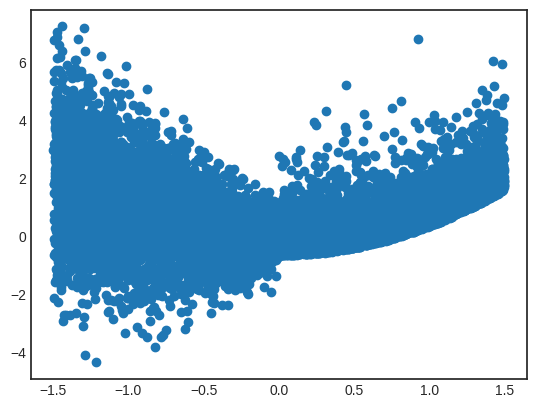

In [4]:
sim_obj = simulation(coef = 2, rate = 1.5, hetero_value = 0.5)
sim_obj.splitted_exp(n = 10000)
plt.scatter(sim_obj.X[:, 0], sim_obj.y)

In [18]:
for p in p_array:
    data_lists.append(run_additional_example(
        kind = "splitted_exp", 
        n_train=n, 
        p = p,
        rate = 1.5,
        hetero_value = 0.5,
        B_y = 10**3,
        B_x = 10**4,
        min_samples_leaf = 150, 
        random_seed_X=0,
        random_seed = 500, 
        random_state = 45,
        )
        )

Fitting locart to toy example:
Time Elapsed to fit Locart:  1.1313257217407227
Computing metrics
Time Elapsed to compute metrics:  0.21681880950927734
Fitting loforest to example:
Time Elapsed to fit Loforest:  6.385116815567017
Computing metrics
Time Elapsed to compute metrics for Loforest:  0.31614065170288086
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.3103539943695068
Computing metrics
Time Elapsed to compute metrics:  0.3690652847290039
Fitting A-loforest to example:
Time Elapsed to fit A-loforest:  6.4865617752075195
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.4671344757080078
Fitting regression split
Time Elapsed to fit regression split:  0.13916277885437012
Computing metrics
Time Elapsed to compute statistics for regression split:  0.21231794357299805
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  17.027389764785767
Computing metrics
Time Elapsed to compute statistics for weighted regression split

100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


Time Elapsed to fit ACPI:  112.15377306938171
Computing metrics
Fitting locart to toy example:
Time Elapsed to fit Locart:  0.9107506275177002
Computing metrics
Time Elapsed to compute metrics:  0.20503807067871094
Fitting loforest to example:
Time Elapsed to fit Loforest:  5.555496692657471
Computing metrics
Time Elapsed to compute metrics for Loforest:  0.3077981472015381
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.1435463428497314
Computing metrics
Time Elapsed to compute metrics:  0.3550255298614502
Fitting A-loforest to example:
Time Elapsed to fit A-loforest:  6.006304025650024
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.4530982971191406
Fitting regression split
Time Elapsed to fit regression split:  0.1343860626220703
Computing metrics
Time Elapsed to compute statistics for regression split:  0.20389938354492188
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  16.293986558914185
Computing metrics
Tim

100%|██████████| 50/50 [01:57<00:00,  2.34s/it]


Time Elapsed to fit ACPI:  123.37822127342224
Computing metrics
Fitting locart to toy example:
Time Elapsed to fit Locart:  0.918562650680542
Computing metrics
Time Elapsed to compute metrics:  0.21104907989501953
Fitting loforest to example:
Time Elapsed to fit Loforest:  5.603495359420776
Computing metrics
Time Elapsed to compute metrics for Loforest:  0.3089487552642822
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.2113513946533203
Computing metrics
Time Elapsed to compute metrics:  0.37991929054260254
Fitting A-loforest to example:
Time Elapsed to fit A-loforest:  6.1852500438690186
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.4583556652069092
Fitting regression split
Time Elapsed to fit regression split:  0.136749267578125
Computing metrics
Time Elapsed to compute statistics for regression split:  0.20706510543823242
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  16.388948917388916
Computing metrics
Tim

100%|██████████| 50/50 [01:57<00:00,  2.36s/it]


Time Elapsed to fit ACPI:  124.27630519866943
Computing metrics


In [19]:
data_lists[0].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.9069,0.020887
1,LOCART,0.9022,0.028553
2,A-LOFOREST,0.9084,0.020521
3,A-LOCART,0.9022,0.028553
4,Regresion split,0.8999,0.096982
5,Weighted regression split,0.9012,0.041359
6,Mondrian,0.9014,0.036207
7,QRF-TC,0.9046,0.036073


In [20]:
data_lists[1].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.9009,0.034218
1,LOCART,0.8947,0.043348
2,A-LOFOREST,0.9026,0.034403
3,A-LOCART,0.8952,0.043909
4,Regresion split,0.8951,0.074161
5,Weighted regression split,0.8993,0.046243
6,Mondrian,0.8976,0.044813
7,QRF-TC,0.9050,0.042979


In [21]:
data_lists[2].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.9052,0.038863
1,LOCART,0.8948,0.051250
2,A-LOFOREST,0.9050,0.037998
3,A-LOCART,0.8980,0.044978
4,Regresion split,0.8993,0.062201
5,Weighted regression split,0.9007,0.044758
6,Mondrian,0.9018,0.046764
7,QRF-TC,0.9024,0.045437


## Correlated homoscedastic example:

In [4]:
data_lists_corr = []
p_array = np.array([1])
n = 10000

In [25]:
for p in p_array:
    data_lists_corr.append(run_additional_example(
        kind = "correlated_homoscedastic", 
        n_train=n, 
        p = p, 
        coef = 2, 
        rate = 1, 
        B_y = 10**3, 
        min_samples_leaf = 150, 
        random_seed = 500, 
        random_state = 45,
        rho = 0.7
        )
        )

3.9375712487099315
-3.562584108066762
3.8238157666707946
-4.050973456353878
Fitting locart to toy example:
Time Elapsed to fit Locart:  0.8420150279998779
Computing metrics
Time Elapsed to compute metrics:  0.11944103240966797
Fitting loforest to example:
Time Elapsed to fit Loforest:  6.52992582321167
Computing metrics
Time Elapsed to compute metrics for Loforest:  0.170271635055542
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.1445517539978027
Computing metrics
Time Elapsed to compute metrics:  0.20969057083129883
Fitting A-loforest to example:
Time Elapsed to fit A-loforest:  6.876238584518433
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.264087438583374
Fitting regression split
Time Elapsed to fit regression split:  0.13370132446289062
Computing metrics
Time Elapsed to compute statistics for regression split:  0.11855363845825195
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  18.955026388168335
Computing 

100%|██████████| 50/50 [01:52<00:00,  2.24s/it]


Time Elapsed to fit ACPI:  117.44664645195007
Computing metrics


In [26]:
data_lists_corr[0].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.9032,0.013335
1,LOCART,0.9002,0.011062
2,A-LOFOREST,0.9030,0.013184
3,A-LOCART,0.9002,0.011062
4,Regresion split,0.9002,0.011062
5,Weighted regression split,0.9072,0.035454
6,Mondrian,0.9036,0.018493
7,QRF-TC,0.8954,0.030523


In [26]:
data_lists_corr[1].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.8990,0.013559
1,LOCART,0.8952,0.012026
2,A-LOFOREST,0.8982,0.013575
3,A-LOCART,0.8952,0.012026
4,Regresion split,0.8952,0.012025
5,Weighted regression split,0.9036,0.036673
6,Mondrian,0.8950,0.016803
7,QRF-TC,0.9046,0.031222


In [27]:
data_lists_corr[2].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.8934,0.013288
1,LOCART,0.8878,0.011591
2,A-LOFOREST,0.8926,0.013229
3,A-LOCART,0.8878,0.011591
4,Regresion split,0.8878,0.011594
5,Weighted regression split,0.8962,0.036099
6,Mondrian,0.8928,0.018325
7,QRF-TC,0.8802,0.033872


## Correlated heteroscedastisc example:

In [40]:
data_lists_corr_het = []
p_array = np.array([1, 3, 5])
n = 10000

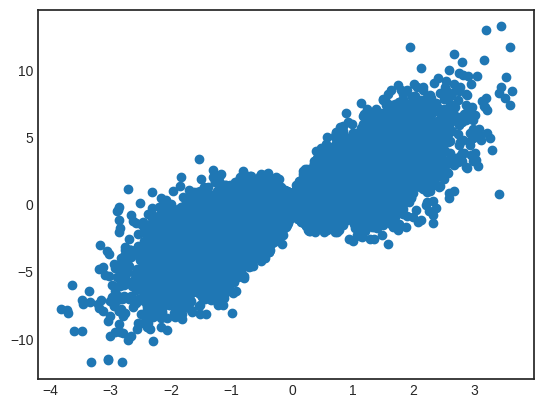

In [28]:
sim_obj = simulation(coef = 2, hetero_value = 0.05, rho = 0.7)
sim_obj.correlated_heteroscedastic(n = 20000)
data = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = False)
plt.figure()
plt.scatter(sim_obj.X[:, 0], sim_obj.y)
plt.show()

In [29]:
rf = RandomForestRegressor(random_state = 5)
rf.fit(data["X_train"], data["y_train"])

RandomForestRegressor(random_state=5)

In [30]:
icp = RegressionSplit(base_model = rf, alpha = 0.1, is_fitted = True)
icp.fit(data["X_train"], data["y_train"])
icp.calibrate(data["X_test"], data["y_test"])

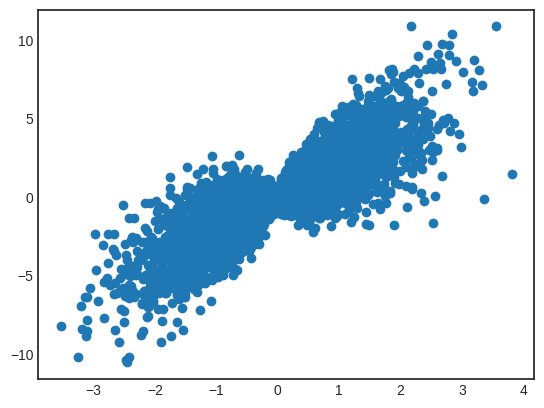

In [31]:
X_test = make_correlated_design(n_samples = 5000, n_features = 20, rho = 0.7, random_state = 90)
y_test = sim_obj.correlated_heteroscedastic_r(X_test[:, 0], B = 1)
plt.figure()
plt.scatter(X_test[:, 0], y_test)
plt.show()

In [32]:
X_test = make_correlated_design(n_samples = 5000, n_features = 20, rho = 0.7, random_state = 90)
y_test = sim_obj.correlated_heteroscedastic_r(X_test[:, 0], B = 1).flatten()
pred = icp.predict(X_test)
np.mean(np.logical_and(pred[:, 0] <= y_test, y_test <= pred[:, 1]))

0.8992

In [9]:
icp.predict(X_test)

array([[-2.14764655,  2.2259772 ],
       [-1.83404524,  2.53957852],
       [-2.81758171,  1.55604204],
       ...,
       [-6.5592762 , -2.18565245],
       [-2.3410617 ,  2.03256205],
       [-0.57570523,  3.79791853]])

In [41]:
for p in p_array:
    data_lists_corr_het.append(run_additional_example(
        kind = "correlated_heteroscedastic", 
        n_train= n, 
        p = p, 
        coef = 2,
        B_y = 10**3,
        B_x = 5000,
        min_samples_leaf = 150, 
        random_seed = 1250,
        random_seed_X = 25,
        hetero_value = 0.25,
        random_state = 45,
        split_mondrian = False,
        rho = 0.7
        )
        )

Fitting locart to toy example:
Time Elapsed to fit Locart:  1.1572678089141846
Computing metrics
Time Elapsed to compute metrics:  0.12475156784057617
Fitting loforest to example:
Time Elapsed to fit Loforest:  5.836666822433472
Computing metrics
Time Elapsed to compute metrics for Loforest:  0.16636872291564941
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.158182144165039
Computing metrics
Time Elapsed to compute metrics:  0.2052316665649414
Fitting A-loforest to example:
Time Elapsed to fit A-loforest:  5.780074596405029
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.2633671760559082
Fitting regression split
Time Elapsed to fit regression split:  0.13765835762023926
Computing metrics
Time Elapsed to compute statistics for regression split:  0.11841607093811035
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  14.657938241958618
Computing metrics
Time Elapsed to compute statistics for weighted regression split: 

100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


Time Elapsed to fit ACPI:  116.33891415596008
Computing metrics
Fitting locart to toy example:
Time Elapsed to fit Locart:  1.4882750511169434
Computing metrics
Time Elapsed to compute metrics:  0.12106037139892578
Fitting loforest to example:
Time Elapsed to fit Loforest:  7.512692213058472
Computing metrics
Time Elapsed to compute metrics for Loforest:  0.18455767631530762
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.378258466720581
Computing metrics
Time Elapsed to compute metrics:  0.21013498306274414
Fitting A-loforest to example:
Time Elapsed to fit A-loforest:  6.141479730606079
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.2610013484954834
Fitting regression split
Time Elapsed to fit regression split:  0.14012455940246582
Computing metrics
Time Elapsed to compute statistics for regression split:  0.12777137756347656
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  15.602736234664917
Computing metrics
T

100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


Time Elapsed to fit ACPI:  124.05761742591858
Computing metrics
Fitting locart to toy example:
Time Elapsed to fit Locart:  1.4479029178619385
Computing metrics
Time Elapsed to compute metrics:  0.12941837310791016
Fitting loforest to example:
Time Elapsed to fit Loforest:  7.762179851531982
Computing metrics
Time Elapsed to compute metrics for Loforest:  0.1701974868774414
Fitting A-locart to toy example:
Time Elapsed to fit A-Locart:  1.214782953262329
Computing metrics
Time Elapsed to compute metrics:  0.20898938179016113
Fitting A-loforest to example:
Time Elapsed to fit A-loforest:  5.767618894577026
Computing metrics
Time Elapsed to compute metrics for A-loforest:  0.26435256004333496
Fitting regression split
Time Elapsed to fit regression split:  0.13582730293273926
Computing metrics
Time Elapsed to compute statistics for regression split:  0.11685848236083984
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  15.362689733505249
Computing metrics
T

100%|██████████| 50/50 [02:05<00:00,  2.50s/it]


Time Elapsed to fit ACPI:  131.36235189437866
Computing metrics


In [42]:
data_lists_corr_het[0].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.9074,0.018923
1,LOCART,0.9044,0.035982
2,A-LOFOREST,0.9070,0.021521
3,A-LOCART,0.9026,0.040988
4,Regresion split,0.8992,0.080349
5,Weighted regression split,0.9056,0.043919
6,Mondrian,0.9042,0.035544
7,QRF-TC,0.9058,0.050203


In [43]:
data_lists_corr_het[1].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.9062,0.035046
1,LOCART,0.8946,0.047608
2,A-LOFOREST,0.9062,0.035901
3,A-LOCART,0.9024,0.043693
4,Regresion split,0.9054,0.075214
5,Weighted regression split,0.9070,0.048067
6,Mondrian,0.9056,0.040869
7,QRF-TC,0.9074,0.049728


In [44]:
data_lists_corr_het[2].iloc[:, [0,2,5]]

,Methods,Average marginal coverage,Average distance
0,LOFOREST,0.9078,0.038740
1,LOCART,0.9010,0.052589
2,A-LOFOREST,0.9028,0.042561
3,A-LOCART,0.9008,0.050484
4,Regresion split,0.9012,0.075408
5,Weighted regression split,0.9070,0.047751
6,Mondrian,0.9024,0.045408
7,QRF-TC,0.9010,0.050793
